### Initial Setup

In [1]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [3]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

Chosen GPU: 0


### Load and Visualize Dataset

In [6]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [7]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [8]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [9]:
# Open zip of dataset
open_zip('trussData.zip')

In [10]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

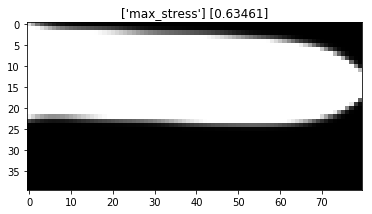

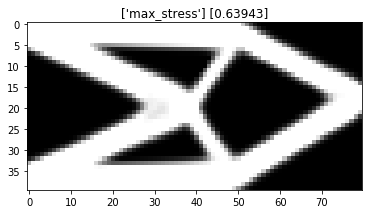

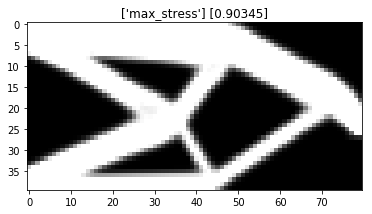

In [11]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [12]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        mse = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar, reg = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
            # Regression Score
            y_true = attribute.cpu().numpy()
            y_pred = reg.cpu().numpy()         
            mse.append(mean_squared_error(y_true, y_pred))
    
    return np.mean(distances), np.mean(mse)

In [13]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [14]:
# VAE with Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE_REG(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE_REG, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=z_dim, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1))
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        r = self.regression(z) # Regression output
        return x, mu, logvar, r

In [15]:
# Loss function for this task, combines reconstruction and KL for the image task and the MSELoss
# for the regression task
def loss_function(reconstruction, image, mu, logvar, attributes, r, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    reg_loss =  torch.nn.MSELoss()
    return reconstruction_loss, kl_loss, reg_loss(attributes, r)

In [16]:
# VAE conv kernel size = 7 z_dim=2
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE_REG(kernel_size=7, z_dim=4)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
train_r2_scores = []
val_recon_scores = []
val_r2_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    reg_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar, reg = model(image)
        reconstruction_loss, kl_loss, reg_loss = loss_function(recon, image, mu, logvar, attribute, reg, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        reg_losses.append(reg_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    print('Regression Loss: ' + str(np.mean(reg_losses)))
    
    # Get training data accuracy
    train_recon_score, train_r2 = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    print('Training MSE Score: ' + str(train_r2))
    train_recon_scores.append(train_recon_score)
    train_r2_scores.append(train_r2)
    
    # Get validation data accuracy
    val_recon_score, val_r2 = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    print('Validation MSE Score: ' + str(val_r2))
    val_recon_scores.append(val_recon_score)
    val_r2_scores.append(val_r2)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.713194910969053
Reconstruction Loss: 0.668320517029081
KL Loss: 0.0015260732392562205
Regression Loss: 0.04334832105918655
Trainig Reconstruction Score: 42.355038
Training MSE Score: 0.0051589007
Validation Reconstruction Score: 42.42407
Validation MSE Score: 0.0048204134

Epoch: 1
Total Loss: 0.6064497070653098
Reconstruction Loss: 0.5998269728251866
KL Loss: 0.0017359498672054282
Regression Loss: 0.00488678553041869
Trainig Reconstruction Score: 39.607414
Training MSE Score: 0.005911796
Validation Reconstruction Score: 39.604763
Validation MSE Score: 0.0055995886

Epoch: 2
Total Loss: 0.5607588112354278
Reconstruction Loss: 0.5544910490512848
KL Loss: 0.0017124346773406225
Regression Loss: 0.004555326121460114
Trainig Reconstruction Score: 38.31076
Training MSE Score: 0.0038769932
Validation Reconstruction Score: 38.266376
Validation MSE Score: 0.003475677

Epoch: 3
Total Loss: 0.5282421163150243
Reconstruction Loss: 0.522464279617582
KL Los

Trainig Reconstruction Score: 33.81853
Training MSE Score: 0.0029262938
Validation Reconstruction Score: 34.076744
Validation MSE Score: 0.003119769

Epoch: 27
Total Loss: 0.4276473964963641
Reconstruction Loss: 0.4227540101323809
KL Loss: 0.0019771377206780016
Regression Loss: 0.00291624921789792
Trainig Reconstruction Score: 33.748806
Training MSE Score: 0.0028146517
Validation Reconstruction Score: 34.02932
Validation MSE Score: 0.0031515271

Epoch: 28
Total Loss: 0.42684834727219173
Reconstruction Loss: 0.4219272200550352
KL Loss: 0.0019880126662818447
Regression Loss: 0.0029331167344935237
Trainig Reconstruction Score: 33.75847
Training MSE Score: 0.0031493437
Validation Reconstruction Score: 34.03895
Validation MSE Score: 0.0034713903

Epoch: 29
Total Loss: 0.4265952557325363
Reconstruction Loss: 0.4215950774294989
KL Loss: 0.0019953633725110975
Regression Loss: 0.0030048148689924606
Trainig Reconstruction Score: 33.708538
Training MSE Score: 0.0027531395
Validation Reconstructio

Trainig Reconstruction Score: 33.593372
Training MSE Score: 0.0025679683
Validation Reconstruction Score: 33.945408
Validation MSE Score: 0.0031653321

Epoch: 54
Total Loss: 0.4151774334056037
Reconstruction Loss: 0.41042893401214053
KL Loss: 0.002038508016682629
Regression Loss: 0.0027099900995381176
Trainig Reconstruction Score: 33.383392
Training MSE Score: 0.0025236446
Validation Reconstruction Score: 33.72532
Validation MSE Score: 0.0032567894

Epoch: 55
Total Loss: 0.4154076950890677
Reconstruction Loss: 0.41072658811296736
KL Loss: 0.002019135715506439
Regression Loss: 0.0026619715512164735
Trainig Reconstruction Score: 33.43962
Training MSE Score: 0.0026698199
Validation Reconstruction Score: 33.78103
Validation MSE Score: 0.003125347

Epoch: 56
Total Loss: 0.41474485525063104
Reconstruction Loss: 0.4100757705313819
KL Loss: 0.002020237265553858
Regression Loss: 0.0026488487750092257
Trainig Reconstruction Score: 33.387108
Training MSE Score: 0.0026158723
Validation Reconstruct

Validation Reconstruction Score: 33.652626
Validation MSE Score: 0.0032134613

Epoch: 81
Total Loss: 0.4115016856363842
Reconstruction Loss: 0.40694843573229655
KL Loss: 0.0020510464723754143
Regression Loss: 0.0025022036919835956
Trainig Reconstruction Score: 33.25029
Training MSE Score: 0.0023427936
Validation Reconstruction Score: 33.657154
Validation MSE Score: 0.003272272

Epoch: 82
Total Loss: 0.4111166707106999
Reconstruction Loss: 0.4065478001322065
KL Loss: 0.002057094482838043
Regression Loss: 0.0025117747011660996
Trainig Reconstruction Score: 33.237545
Training MSE Score: 0.0023189944
Validation Reconstruction Score: 33.672462
Validation MSE Score: 0.003246592

Epoch: 83
Total Loss: 0.4103989903415952
Reconstruction Loss: 0.4059367043631417
KL Loss: 0.0020574620425967234
Regression Loss: 0.0024048198534209015
Trainig Reconstruction Score: 33.25505
Training MSE Score: 0.0024152922
Validation Reconstruction Score: 33.64427
Validation MSE Score: 0.0031631684

Epoch: 84
Total L

Validation Reconstruction Score: 33.627686
Validation MSE Score: 0.0032627168

Epoch: 108
Total Loss: 0.4075353264808655
Reconstruction Loss: 0.40328548082283566
KL Loss: 0.0020495151851459273
Regression Loss: 0.0022003330880709525
Trainig Reconstruction Score: 33.130962
Training MSE Score: 0.0020599319
Validation Reconstruction Score: 33.603603
Validation MSE Score: 0.0033421158

Epoch: 109
Total Loss: 0.40778173165661946
Reconstruction Loss: 0.403569980604308
KL Loss: 0.0020456057707113878
Regression Loss: 0.002166141937154212
Trainig Reconstruction Score: 33.130516
Training MSE Score: 0.0020857735
Validation Reconstruction Score: 33.58492
Validation MSE Score: 0.0032568693

Epoch: 110
Total Loss: 0.40778459693704333
Reconstruction Loss: 0.403574937582016
KL Loss: 0.0020366749759497386
Regression Loss: 0.002172986145264336
Trainig Reconstruction Score: 33.108444
Training MSE Score: 0.0021922684
Validation Reconstruction Score: 33.648937
Validation MSE Score: 0.0034057803

Epoch: 111


Total Loss: 0.4049176071371351
Reconstruction Loss: 0.40095090355191915
KL Loss: 0.002027814797059234
Regression Loss: 0.001938891303143464
Trainig Reconstruction Score: 33.066093
Training MSE Score: 0.0018492403
Validation Reconstruction Score: 33.59475
Validation MSE Score: 0.003430871

Epoch: 136
Total Loss: 0.4060256336416517
Reconstruction Loss: 0.40198245857443127
KL Loss: 0.0020261257886886597
Regression Loss: 0.002017051335341031
Trainig Reconstruction Score: 33.195984
Training MSE Score: 0.0021648677
Validation Reconstruction Score: 33.632816
Validation MSE Score: 0.003774219

Epoch: 137
Total Loss: 0.4058839291334152
Reconstruction Loss: 0.4018650263547897
KL Loss: 0.002039613702800125
Regression Loss: 0.0019792878189556565
Trainig Reconstruction Score: 33.134888
Training MSE Score: 0.0019545914
Validation Reconstruction Score: 33.67669
Validation MSE Score: 0.0034251162

Epoch: 138
Total Loss: 0.4049429978643145
Reconstruction Loss: 0.40100291967391966
KL Loss: 0.00202430727

Trainig Reconstruction Score: 32.864532
Training MSE Score: 0.0016282543
Validation Reconstruction Score: 33.44447
Validation MSE Score: 0.0033965544

Epoch: 162
Total Loss: 0.40062023316110884
Reconstruction Loss: 0.3969608609165464
KL Loss: 0.0020017038714805883
Regression Loss: 0.0016576703276119328
Trainig Reconstruction Score: 32.86035
Training MSE Score: 0.0016034985
Validation Reconstruction Score: 33.428593
Validation MSE Score: 0.0034721845
New Best Model Saved!

Epoch: 163
Total Loss: 0.40051615621362413
Reconstruction Loss: 0.3968891731330327
KL Loss: 0.0019999519073670463
Regression Loss: 0.0016270292128735622
Trainig Reconstruction Score: 32.856903
Training MSE Score: 0.0016117619
Validation Reconstruction Score: 33.436962
Validation MSE Score: 0.0034832973

Epoch: 164
Total Loss: 0.4005052481378828
Reconstruction Loss: 0.39688064796583994
KL Loss: 0.0020000427329380597
Regression Loss: 0.0016245573942017342
Trainig Reconstruction Score: 32.859447
Training MSE Score: 0.001

Trainig Reconstruction Score: 32.85039
Training MSE Score: 0.0015267134
Validation Reconstruction Score: 33.437187
Validation MSE Score: 0.0034307085

Epoch: 189
Total Loss: 0.40007436701229643
Reconstruction Loss: 0.3965475810425622
KL Loss: 0.001977209813360657
Regression Loss: 0.0015495779269258491
Trainig Reconstruction Score: 32.85082
Training MSE Score: 0.0015115807
Validation Reconstruction Score: 33.447327
Validation MSE Score: 0.0034953922

Epoch: 190
Total Loss: 0.40001771322318486
Reconstruction Loss: 0.39650157008852277
KL Loss: 0.001977239184946354
Regression Loss: 0.0015389038553361648
Trainig Reconstruction Score: 32.847744
Training MSE Score: 0.0014936574
Validation Reconstruction Score: 33.447296
Validation MSE Score: 0.0034473217

Epoch: 191
Total Loss: 0.400067794748715
Reconstruction Loss: 0.39656493365764617
KL Loss: 0.001974359878139304
Regression Loss: 0.0015285016748488747
Trainig Reconstruction Score: 32.843636
Training MSE Score: 0.0015054778
Validation Recons

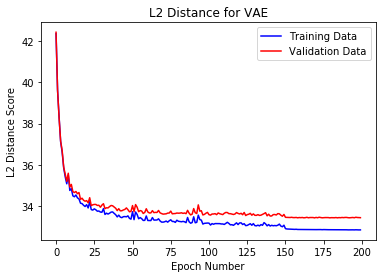

In [17]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.show()

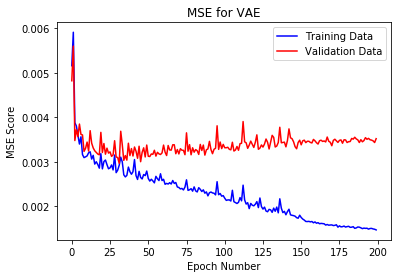

In [18]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_r2_scores, 'b', range(n_epochs), val_r2_scores, 'r')
plt.title('MSE for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('MSE Score')
plt.show()

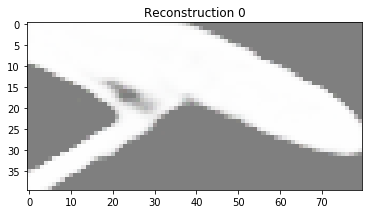

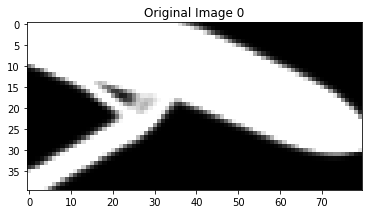

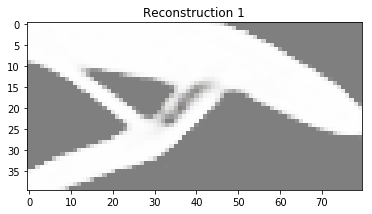

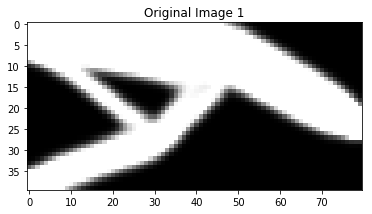

In [19]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var, r = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            if len(model_output) == 2:
                return model_output, ground_truth
            
model_out, gt = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [20]:
test_recon_score, test_mse_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))
print('Test MSE Score: ' + str(test_mse_score))

Test L2 Score: 33.373837
Test MSE Score: 0.0031959342
